# Ch 3. 監督式學習：分類
## 3-6. 決策樹
 - 3-6-1. 資訊增益
 - [3-6-2. 決策樹分類與迴歸](#sec3_6_2)
 - [3-6-3. 隨機森林](#sec3_6_3)

## 3-7. K最近鄰
 - [3-7. K-NN](#sec3_7)
***

<a id='sec3_6_2'></a>
## 3-6-2. 決策樹分類與迴歸

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

df = pd.read_csv('Pokemon_894_13.csv')
df['hasType2'] = df['Type2'].notnull().astype(int)
X, y = df.loc[:, 'HP':'Speed'], df['hasType2']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# 建立決策樹分類器
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)

from sklearn.metrics import classification_report
# 產生分類報告
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.53      0.53        95
           1       0.65      0.66      0.66       129

    accuracy                           0.60       224
   macro avg       0.59      0.59      0.59       224
weighted avg       0.60      0.60      0.60       224



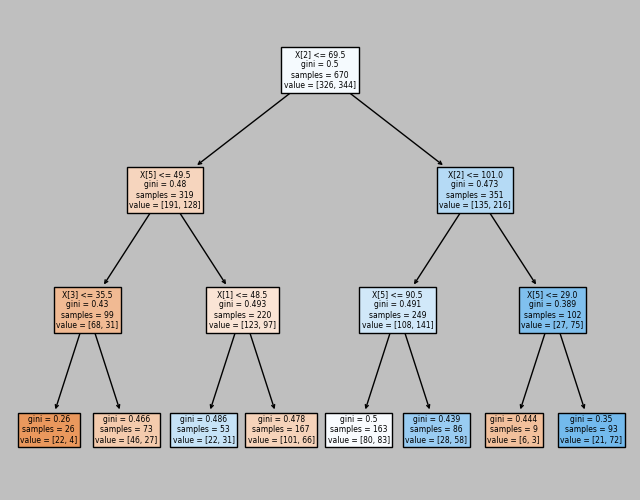

In [2]:
import matplotlib.pyplot as plt
plt.style.use('classic')
from sklearn.tree import plot_tree

plt.figure(dpi=100)
plot_tree(clf, filled=True);

In [3]:
import graphviz
from sklearn import tree

# 設定輸出格式
dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=X.columns,  
                     class_names=['0', '1'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data) 
# 設定檔名
graph.render("pokemon")

'pokemon.pdf'

In [4]:
from pydotplus import graph_from_dot_data

# 設定決策樹樹狀圖輸出格式
graph = graph_from_dot_data(dot_data)
# 輸出 .png 圖檔
graph.write_png('tree.png')
# 輸出 .pdf 檔
graph.write_pdf('tree.pdf')

True

(0.0, 6.0)

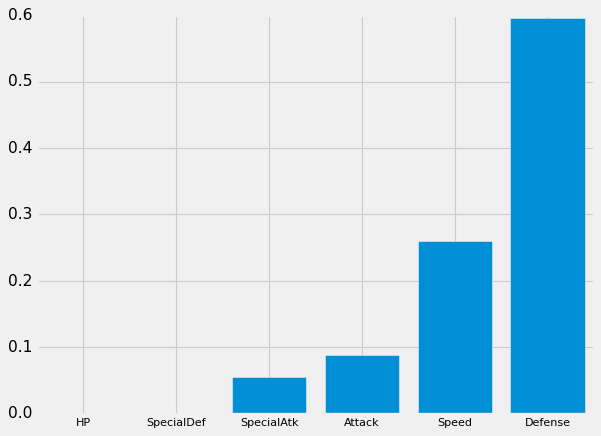

In [5]:
import numpy as np
plt.style.use('fivethirtyeight')

# 取出特徵重要性與排序後的索引值
idx = np.argsort(clf.feature_importances_)
# 放置柱狀圖的橫軸位置
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

# 由小到大繪製特徵重要性的柱狀圖
plt.bar(tree_indices, clf.feature_importances_[idx])
plt.xticks(tree_indices, labels=X.columns[idx], fontsize=10)
plt.xlim((0, len(clf.feature_importances_)))

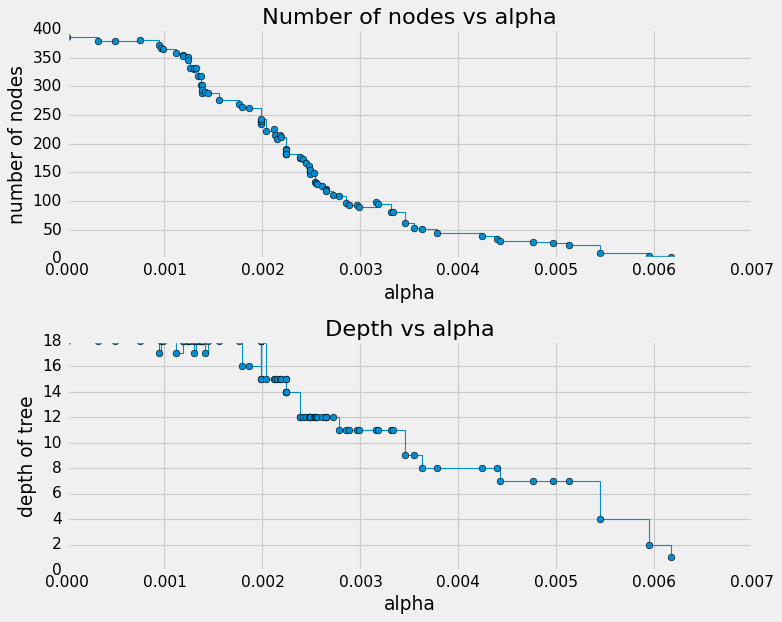

In [6]:
# 參考來源 https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html
clf = DecisionTreeClassifier()

# 依最小成本修剪方式計算修剪過程
path = clf.cost_complexity_pruning_path(X_train, y_train)
# 回傳修剪過程的有效 alpha 值
ccp_alphas = path.ccp_alphas

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
    
# 過濾掉最後只剩一個節點的決策樹
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].plot(ccp_alphas, node_counts, marker='o', lw=1, drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', lw=1, drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

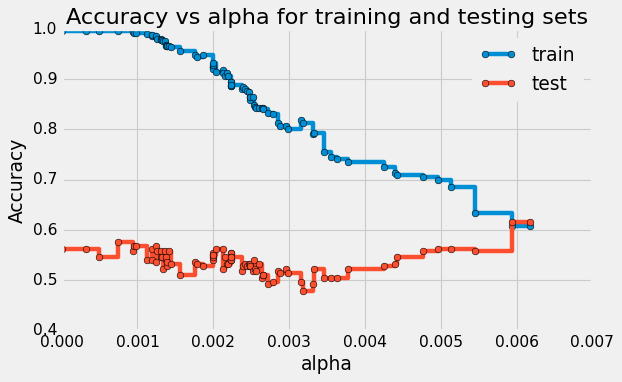

In [7]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_xlabel("alpha")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
fig.tight_layout()

<a id='sec3_6_3'></a>
## 3-6-3. 隨機森林

In [8]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=3, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.56      0.54        95
           1       0.66      0.63      0.64       129

    accuracy                           0.60       224
   macro avg       0.59      0.59      0.59       224
weighted avg       0.60      0.60      0.60       224



(0.0, 0.6)

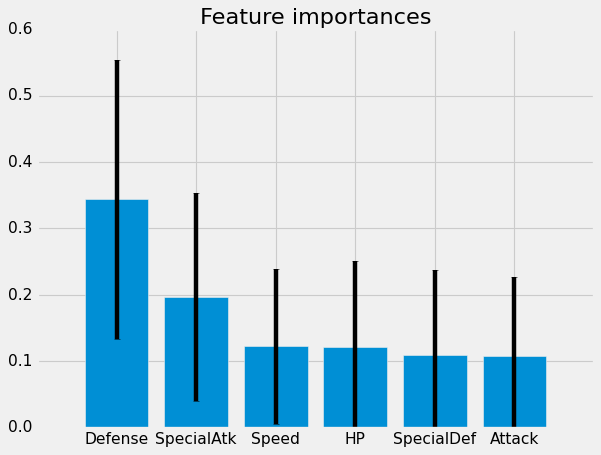

In [9]:
importances = clf.feature_importances_
std = np.std([t.feature_importances_ for t in clf.estimators_], axis=0)
idx = np.argsort(importances)[::-1]

plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[idx], 
        yerr=std[idx], align="center")
plt.xticks(range(X.shape[1]), labels=X.columns[idx])
plt.xlim([-1, X.shape[1]])
plt.ylim([0, 0.6])

In [10]:
from sklearn.feature_selection import SelectFromModel

# 建立特徵選取器，門檻值預設為重要性的平均值
selector = SelectFromModel(clf)
selector.fit(X_train, y_train)
print('門檻值 =', selector.threshold_)
print('特徵遮罩：', selector.get_support())

# 選出新特徵，重新訓練隨機森林
X_train_new = selector.transform(X_train)
clf.fit(X_train_new, y_train)

X_test_new = selector.transform(X_test)
y_pred = clf.predict(X_test_new)
print(classification_report(y_test, y_pred))

門檻值 = 0.1666666666666667
特徵遮罩： [False False  True  True False False]
              precision    recall  f1-score   support

           0       0.53      0.60      0.56        95
           1       0.68      0.61      0.64       129

    accuracy                           0.61       224
   macro avg       0.60      0.61      0.60       224
weighted avg       0.61      0.61      0.61       224



<a id='sec3_7'></a>
## 3-7. K-NN

In [11]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# 特徵標準化
scale = StandardScaler().fit(X_train)
X_train_std = scale.transform(X_train)
# 建立最近鄰模型
neighbors = NearestNeighbors(n_neighbors=3).fit(X_train_std)

# 未知寶可夢的屬性
new_poke = [[120, 50, 80, 100, 150, 90]]
new_poke_std = scale.transform(new_poke)
# 取出最近鄰的距離與索引值
dist, idx = neighbors.kneighbors(new_poke_std)
for d, i in enumerate(idx.ravel()):
    print(df.iloc[i, 1], np.array(X_train.iloc[i, :]), 
          '，標準化後的距離 = %.3f'% dist[0][d])

小磁怪 [100  77  77 128 128  90] ，標準化後的距離 = 1.623
幼基拉斯 [109  53  47 127 131 103] ，標準化後的距離 = 1.642
蚊香蝌蚪 [ 95  65  65 110 130  60] ，標準化後的距離 = 1.730


In [12]:
from sklearn.neighbors import KNeighborsClassifier

# 建立 KNN 分類器，預設 k=5
knn = KNeighborsClassifier(n_jobs=-1)
knn.fit(X_train_std, y_train)
# 輸出預測結果
print(knn.predict(new_poke_std))
# 輸出預測結果的機率
print(knn.predict_proba(new_poke_std))

[0]
[[0.6 0.4]]


In [13]:
from sklearn.neighbors import RadiusNeighborsClassifier
# 建立半徑鄰分類器，設定離群值類別為 2
rn = RadiusNeighborsClassifier(radius=2, outlier_label=2)
rn.fit(X_train_std, y_train)
print(rn.predict(new_poke_std))
print(rn.predict_proba(new_poke_std))
print(rn.predict([[3., 3., 3., 1., 1., 1.]]))

[0]
[[0.57142857 0.42857143]]
[2]


C:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:566: UserWarning: Outlier label 2 is not in training classes. All class probabilities of outliers will be assigned with 0.
  ''.format(self.outlier_label_[k]))
